# Deglinting comparison for a Landsat-8 scene

This notebook demonstrates the different deglinting methods available witin the sungc module:

* Hedley et al., 2005 (correlation approach)
* Cox and Munk 1954 (statistical/geometry approach)
* NIR/SWIR subtraction (e.g. Dierssen et al., 2015)

In [1]:
import numpy
import matplotlib.pyplot as plt
import rasterio
import datacube
from sungc import deglint, visualise
from sungc import rasterio_funcs as rf

In [2]:
dc = datacube.Datacube(env="water-atcor", config="/g/data/r78/dea-atmospheric-correction-over-water/datacube.conf")

In [3]:
query = {
    "product": "ga_ls8c_aard_3",
    "region_code": "113082",
    "time": ("2020-02-03", "2020-02-04")
}

The `sungc` module enables a user to supply an opendatacube `Dataset` object as returned by `find_datasets`.  The premise is that deglinting is more robust prior to resampling as opposed to resampling upfront that generally occur when using `dc.load`.

In [4]:
dataset = dc.find_datasets(**query)[0]

The `ga_ls8c_aard_3` product is comprised of the following sub-products:

* lmbskyg `lambertian sky glint corrected`
* oa `observation attributes`

In the same way that the `ga_ls8c_ard_3` product which contains the following sub-products:

* nbar `nadir corrected brdf adjusted reflectance
* nbart `nadir corrected brdf adjusted reflectance terrain illumination correction
* oa `observation attributes`

In [5]:
sub_product = "lmbskyg"
g = deglint.GlintCorr(dataset, sub_product)

## Hedley 2005
The Hedley method requires a Region Of Interest to be selected (or provided) that contains both deep water and sun glint affected pixels.

In [6]:
%matplotlib
hedley_xarr = g.hedley_2005(
    vis_bands=["1", "2", "3", "4"],
    corr_band="6",
)[0]

Using matplotlib backend: Qt5Agg


## Cox and Munk 1954

In [7]:
cm_xarr = g.cox_munk(
    vis_bands=["1", "2", "3", "4"],
    wind_speed=5,
)[0]

## Glint subtraction

In [8]:
subtract_xarr = g.glint_subtraction(
    vis_bands=["1", "2", "3", "4"],
    corr_band="6",
)[0]

## Comparison

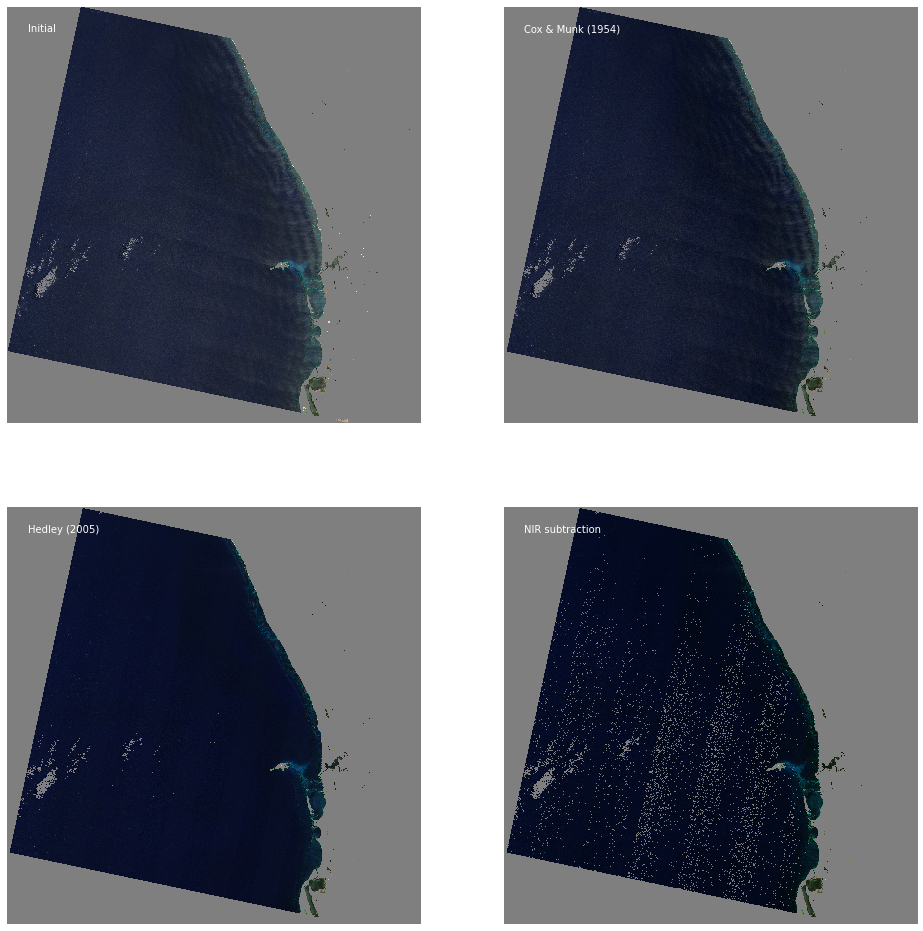

In [9]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13))
ini_rgb, ini_meta = rf.quicklook_rgb(
    rgb_bandlist=g.rgb_bandlist,
    scale_factor=g.scale_factor,
    dwnscale_factor=1,
    mask_nodata=True
)
axes[0, 0].imshow(ini_rgb, interpolation="None")
axes[0, 0].axis("off")
axes[0, 0].annotate(
    "Initial",
    xy=(0.05, 0.94),
    xycoords="axes fraction",
    fontsize=10,
    color="w",
)
rgb_varlist = [f"{sub_product}_red", f"{sub_product}_green", f"{sub_product}_blue"]
annotate_list = [
    "Cox & Munk (1954)",
    "Hedley (2005)",
    "NIR subtraction",
]
for t in range(cm_xarr.dims["time"]):
    master_ds = [
        cm_xarr.isel(time=t),
        hedley_xarr.isel(time=t),
        subtract_xarr.isel(time=t),
    ]

    for i, ds_i in enumerate(master_ds):
        rix, cix = numpy.unravel_index(i+1, (2, 2))

        refl_im = numpy.array(
            [
                ds_i.variables[rgb_varlist[0]].values,  # R
                ds_i.variables[rgb_varlist[1]].values,  # G
                ds_i.variables[rgb_varlist[2]].values,  # B
            ],
            order="C"
        )

        rgb_im = visualise.seadas_style_rgb(refl_im, [0, 1, 2], 10000.0, True)

        axes[rix, cix].imshow(rgb_im, interpolation="None")
        axes[rix, cix].axis("off")
        axes[rix, cix].annotate(
            annotate_list[i],
            xy=(0.05, 0.94),
            xycoords="axes fraction",
            fontsize=10,
            color="w",
        )
    fig.subplots_adjust(
        left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.01
    )